**Exploring MTA Tweets**

In [1]:
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence
import gensim
import os
import re

In [2]:
# Load the data scraped from Twitter's API
df = pd.read_csv('./more_tweets_plus.csv')

In [3]:
df.head()

date  retweets  favorites  \
0  2018-08-01 19:52:00         0          0   
1  2018-08-01 19:49:00         0          0   
2  2018-08-01 19:39:00         0          0   
3  2018-08-01 19:38:00         0          0   
4  2018-08-01 19:36:00         0          0   

                                                text mentions hashtags  \
0  Good Evening. We are working to address these ...      NaN      NaN   
1  Good Evening. Can you tell us your location an...      NaN      NaN   
2  Thank you for reporting this information. We w...      NaN      NaN   
3  You're very welcome and I hope you have a grea...      NaN      NaN   
4  Thank you again for reporting this. We will at...      NaN      NaN   

             id                                          permalink  \
0  1.024805e+18  https://twitter.com/NYCTSubway/status/10248050...   
1  1.024804e+18  https://twitter.com/NYCTSubway/status/10248044...   
2  1.024802e+18  https://twitter.com/NYCTSubway/status/10248017...   
3  1.024802e+18  https://twitter.com/NYCTSubway/status/10248015...   
4  1.024801e+18  https://twitter.com/NYCTSubway/status/10248010...   

                                         tweet_clean  polarity  subjectivity  \
0  good evening. we are working to address these ...       0.7         0.600   
1  good evening. can you tell us your location an...       0.7         0.600   
2  thank you for reporting this information. we w...       0.0         0.000   
3  you're very welcome and i hope you have a grea...       0.9         0.875   
4  thank you again for reporting this. we will at...       0.8         0.750   

   sig  log_rt  log_faves  
0  ^JZ     0.0        0.0  
1  ^JZ     0.0        0.0  
2  ^JZ     0.0        0.0  
3  ^JZ     0.0        0.0  
4  ^JZ     0.0        0.0

In [118]:
# df['text'] = [re.sub(r'^@\S+', '', doc) for doc in df.text]

In [119]:
# df['text'] = [re.sub(r'\^\S+', '', doc) for doc in df.text]

In [120]:
# df['text'] = [re.sub(r'https:\S+', '', doc) for doc in df.text]

In [121]:
# df['text'] = [doc.lower() for doc in df.text]

In [4]:
# use RegEx to clean up the tweets
def cleany(tweet):
    if '@' in tweet:
        tweet = re.sub('@\S+ ','', tweet)
    tweet = re.sub('\^\S+','', tweet)
    tweet = re.sub('https:\S+','', tweet)
    return tweet.lower()

In [5]:
df['cleaned_text'] = [cleany(doc) for doc in df.text]

In [6]:
# another column with the mentions still in them
def cleany_ats(tweet):
    tweet = re.sub('\^\S+','', tweet)
    tweet = re.sub('https:\S+','', tweet)
    return tweet.lower()

In [7]:
df['with_ats'] = [cleany_ats(doc) for doc in df.text]

In [8]:
df.head()

date  retweets  favorites  \
0  2018-08-01 19:52:00         0          0   
1  2018-08-01 19:49:00         0          0   
2  2018-08-01 19:39:00         0          0   
3  2018-08-01 19:38:00         0          0   
4  2018-08-01 19:36:00         0          0   

                                                text mentions hashtags  \
0  Good Evening. We are working to address these ...      NaN      NaN   
1  Good Evening. Can you tell us your location an...      NaN      NaN   
2  Thank you for reporting this information. We w...      NaN      NaN   
3  You're very welcome and I hope you have a grea...      NaN      NaN   
4  Thank you again for reporting this. We will at...      NaN      NaN   

             id                                          permalink  \
0  1.024805e+18  https://twitter.com/NYCTSubway/status/10248050...   
1  1.024804e+18  https://twitter.com/NYCTSubway/status/10248044...   
2  1.024802e+18  https://twitter.com/NYCTSubway/status/10248017...   
3  1.024802e+18  https://twitter.com/NYCTSubway/status/10248015...   
4  1.024801e+18  https://twitter.com/NYCTSubway/status/10248010...   

                                         tweet_clean  polarity  subjectivity  \
0  good evening. we are working to address these ...       0.7         0.600   
1  good evening. can you tell us your location an...       0.7         0.600   
2  thank you for reporting this information. we w...       0.0         0.000   
3  you're very welcome and i hope you have a grea...       0.9         0.875   
4  thank you again for reporting this. we will at...       0.8         0.750   

   sig  log_rt  log_faves                                       cleaned_text  \
0  ^JZ     0.0        0.0  good evening. we are working to address these ...   
1  ^JZ     0.0        0.0  good evening. can you tell us your location an...   
2  ^JZ     0.0        0.0  thank you for reporting this information. we w...   
3  ^JZ     0.0        0.0  you're very welcome and i hope you have a grea...   
4  ^JZ     0.0        0.0  thank you again for reporting this. we will at...   

                                            with_ats  
0  good evening. we are working to address these ...  
1  good evening. can you tell us your location an...  
2  thank you for reporting this information. we w...  
3  you're very welcome and i hope you have a grea...  
4  thank you again for reporting this. we will at...

In [9]:
from nltk import WordNetLemmatizer, RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

stops = list(ENGLISH_STOP_WORDS)
# custom stop words related to everyday MTA language
train_words = ['train', 'trains', 'st', 'av', 'http', 'a', 'b','c','d','e','f','g','j','l','m','n',
               'q','r','s','w','z','1','2','3','4','5','6','7']
stops = stops+train_words

In [10]:
def text_process(text):
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stops]
    
    # lemmatizing
    text_processed = [lemmatizer.lemmatize(word) for word in text_processed]

    return text_processed

In [11]:
docs = [text_process(doc) for doc in df.with_ats]

In [12]:
# initiate topic modeling using LDA to see clusters of topics in tweets

from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [118]:
dictionary = corpora.Dictionary(docs)

corpus = [dictionary.doc2bow(doc) for doc in docs]

ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       
                                    num_topics = 2,             
                                    passes = 5,                 
                                    minimum_probability = 0.01)

In [120]:
# gensim prepares interavtive LDA model
# two general categories: service updates and apologies/explanations for those updates
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics       x    y
topic                                         
1      55.079479        1       1  0.2884  0.0
0      44.920528        1       2 -0.2884  0.0, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
5125   Default  36745.000000         regret  36745.000000  30.0000  30.0000
43     Default  43027.000000          delay  43027.000000  29.0000  29.0000
15343  Default  36421.000000   servicealert  36421.000000  28.0000  28.0000
17     Default  19767.000000    supervision  19767.000000  27.0000  27.0000
125    Default  19447.000000           info  19447.000000  26.0000  26.0000
126    Default  18831.000000            mta  18831.000000  25.0000  25.0000
6      Default  23610.000000           time  23610.000000  24.0000  24.0000
68     Default  20035.000000       incident  20035.000000  23.0000  23.0000
134    Default  19975.000000        resumed  19975.000000  22.0000  22.0000
156    Default  18877.000000        problem  18877.000000  21.0000  21.0000
66     Default  18447.000000        earlier  18447.000000  20.0000  20.0000
198    Default  17730.000000        running  17730.000000  19.0000  19.0000
342    Default  17659.000000         travel  17659.000000  18.0000  18.0000
8784   Default  12747.000000            ref  12747.000000  17.0000  17.0000
30     Default  12999.000000      condition  12999.000000  16.0000  16.0000
1145   Default  14889.000000          allow  14889.000000  15.0000  15.0000
70     Default  45156.000000        service  45156.000000  14.0000  14.0000
18     Default  10387.000000          thank  10387.000000  13.0000  13.0000
0      Default  14858.000000     additional  14858.000000  12.0000  12.0000
39     Default   8951.000000         report   8951.000000  11.0000  11.0000
372    Default   8716.000000            com   8716.000000  10.0000  10.0000
292    Default   7875.000000            bit   7875.000000   9.0000   9.0000
296    Default   7874.000000             ly   7874.000000   8.0000   8.0000
381    Default   6999.000000        twitter   6999.000000   7.0000   7.0000
385    Default   9258.000000         signal   9258.000000   6.0000   6.0000
132    Default  13956.000000      following  13956.000000   5.0000   5.0000
705    Default   6434.000000         matter   6434.000000   4.0000   4.0000
9      Default   8490.000000      direction   8490.000000   3.0000   3.0000
78     Default   6765.000000  inconvenience   6765.000000   2.0000   2.0000
378    Default   5813.000000            pic   5813.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
705     Topic2   6433.825684         matter   6434.290039   0.8002  -4.5497
1270    Topic2   5668.395020      reference   5668.857910   0.8002  -4.6763
378     Topic2   5813.387695            pic   5813.884766   0.8002  -4.6511
4       Topic2   5569.349121    information   5569.829102   0.8002  -4.6940
129     Topic2   5164.770996         subway   5165.247070   0.8002  -4.7694
86      Topic2   4980.400391         notify   4980.865234   0.8002  -4.8057
192     Topic2   4925.996582       notified   4926.461914   0.8002  -4.8167
29      Topic2   4680.357422          aware   4680.823242   0.8002  -4.8679
428     Topic2   4891.786133         detail   4892.285156   0.8002  -4.8237
244     Topic2   4372.183105         thanks   4372.649414   0.8002  -4.9360
565     Topic2   4343.497070           note   4343.967773   0.8002  -4.9426
8       Topic2   4683.352539              ä   4683.867676   0.8002  -4.8672
24      Topic2   4242.789551            car   4243.266113   0.8002  -4.9660
230     Topic2   4116.065430         review   4116.528320   0.8002  -4.9963
130     Topic2   3927.256348            www   3927.735596   0.8002  -5.0433
117     Topic2   3695.890625        forward   3696.355469   0.8001  -5.1040
682     Topic2   3448.224365      attention  

In [124]:
ldamodel.show_topics()

[(0,
  '0.060*"regret" + 0.032*"supervision" + 0.032*"info" + 0.031*"mta" + 0.021*"condition" + 0.021*"ref" + 0.017*"thank" + 0.015*"report" + 0.014*"com" + 0.013*"bit"'),
 (1,
  '0.058*"delay" + 0.052*"service" + 0.049*"servicealert" + 0.031*"time" + 0.027*"incident" + 0.027*"resumed" + 0.025*"problem" + 0.025*"earlier" + 0.024*"running" + 0.024*"travel"')]

In [16]:
for i in ldamodel.print_topics(num_topics=3, num_words=5):
    print(i)

(0, '0.057*"delay" + 0.052*"service" + 0.049*"servicealert" + 0.031*"time" + 0.027*"incident"')
(1, '0.061*"regret" + 0.033*"supervision" + 0.032*"info" + 0.031*"mta" + 0.022*"condition"')


**Predict Author**

In [13]:
# create target: author of tweet
# regex the signature which is identified with a "^"
def find_sig(tw):
    if re.search('\^\S{1,4}', tw) != None:
        return re.search('\^\S{1,4}', tw)[0]
    else:
        return None

<input>:2: DeprecationWarning: invalid escape sequence \^
<input>:3: DeprecationWarning: invalid escape sequence \^
<input>:2: DeprecationWarning: invalid escape sequence \^
<input>:3: DeprecationWarning: invalid escape sequence \^
<input>:2: DeprecationWarning: invalid escape sequence \^
<input>:3: DeprecationWarning: invalid escape sequence \^
<ipython-input-13-7dede3188477>:2: DeprecationWarning: invalid escape sequence \^
  if re.search('\^\S{1,4}', tw) != None:
<ipython-input-13-7dede3188477>:3: DeprecationWarning: invalid escape sequence \^
  return re.search('\^\S{1,4}', tw)[0]


In [14]:
df.sig = df.text.map(find_sig)

In [15]:
len(df.sig.unique())

142

In [16]:
v = df.sig.value_counts()[df.sig.value_counts() < 22].index.values

df['sig'] = df.sig.map(lambda x: None if x in v else x)

In [144]:
# clean up some obvious duplicates
df['sig'] = df['sig'].map(lambda x: '^BD' if x == '^BDht' else x)
df['sig'] = df['sig'].map(lambda x: '^GES' if x == '^G.S.' else x)
df['sig'] = df['sig'].map(lambda x: '^GES' if x == '^G.S' else x)
df['sig'] = df['sig'].map(lambda x: '^GES' if x == '^GS' else x)
df['sig'] = df['sig'].map(lambda x: '^KF' if x == '^KFht' else x)

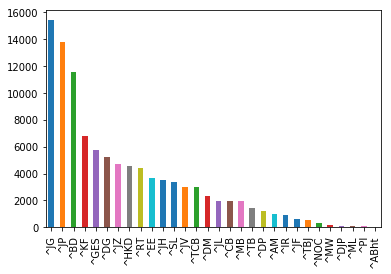

In [145]:
# many individual authors but most done by a handful. we'll look at those
df.sig.value_counts().plot(kind='bar')

In [149]:
df['sig'].value_counts()[0]/len(df.sig) # baseline

0.1031718883098242

In [418]:
sig_names = list(df.sig.unique()) + ['^GS', '^gs']

In [422]:
sig_names.remove(None)

In [424]:
sig_stops = stops + sig_names # for vectorizer

In [425]:
sig_no_carat = [n.replace('^','') for n in sig_names]

In [426]:
list_of_authors = sig_names + sig_no_carat

df.text = df.text.map(lambda x: ' '.join([w for w in x.split() if x not in list_of_authors]))

In [427]:
sig_stops = sig_stops + [n.lower() for n in sig_names] + sig_no_carat + [n.lower() for n in sig_no_carat]

In [428]:
# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt

In [520]:
tweeters = list(df['sig'].value_counts().index)

In [521]:
tweeters[:10]

['^JG', '^JP', '^BD', '^KF', '^GES', '^DG', '^JZ', '^HKD', '^RT', '^EE']

In [522]:
top_n = df['sig'].isin(tweeters[:10])

In [523]:
# Look at only top n most common signatures first

In [544]:
X = df[top_n].text
y = df[top_n].sig

In [545]:
y.value_counts()

^JG     15382
^JP     13759
^BD     11511
^KF      6821
^GES     5762
^DG      5206
^JZ      4714
^HKD     4527
^RT      4442
^EE      3693
Name: sig, dtype: int64

In [546]:
y.value_counts()[0]/len(y)

0.20288325837213289

In [547]:
cv = CountVectorizer(stop_words=sig_stops, ngram_range=(1,4), binary=False, min_df=3)

X = cv.fit_transform(X)

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [549]:
rf=RandomForestClassifier(n_estimators=20, random_state=24)

In [550]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [551]:
rf.score(X_train, y_train)

0.97743660089339102

In [552]:
rf.score(X_test, y_test)

0.79208652070693752

In [553]:
top_feat_importances = pd.DataFrame(list(zip(rf.feature_importances_, cv.get_feature_names())),
             columns=['f_importance','feature']).sort_values('f_importance', ascending=False).head(20)
top_feat_importances

f_importance               feature
25933      0.006591          good evening
64959      0.006346                  time
61677      0.005757           supervision
63703      0.005720                 thank
28848      0.005119                    hi
37829      0.005099              location
63199      0.004789                  tell
50852      0.004534               regrets
40539      0.004356               morning
50183      0.004141             reference
25472      0.004011                  good
59799      0.003989               station
21404      0.003985                    en
48461      0.003833            proceeding
50472      0.003588             referring
26551      0.003408          good morning
64733      0.003396                thanks
10138      0.003297                 bound
42163      0.003222  mta nyc custhelp com
49950      0.003149                   ref

In [554]:
probs = rf.predict_proba(X_test)

In [555]:
max_probs = []
for n in range(len(probs)):
    max_probs.append(max(probs[n]))

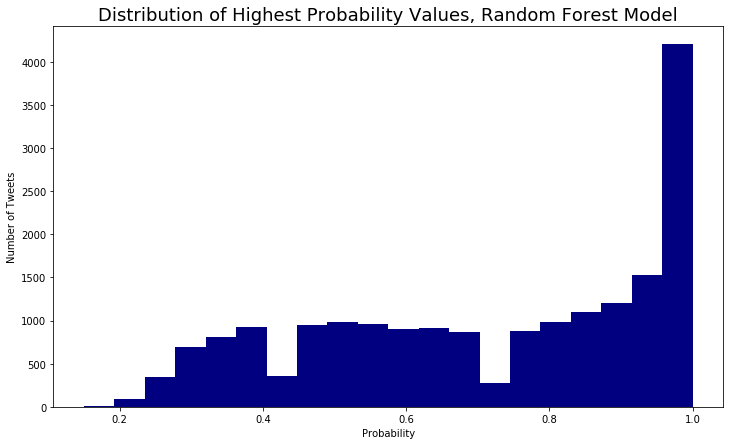

In [557]:
plt.figure(figsize=(12,7))
plt.title("Distribution of Highest Probability Values, Random Forest Model", fontsize=18)
plt.xlabel("Probability")
plt.ylabel("Number of Tweets")
plt.hist(max_probs, color='navy', bins=20);

In [558]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [559]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [560]:
lr.score(X_train, y_train)

0.95406422566916393

In [561]:
lr.score(X_test, y_test)

0.84151938802426796

In [562]:
lr_probs = lr.predict_proba(X_test)

In [563]:
max_lr_probs = []
for n in range(len(lr_probs)):
    max_lr_probs.append(max(lr_probs[n]))

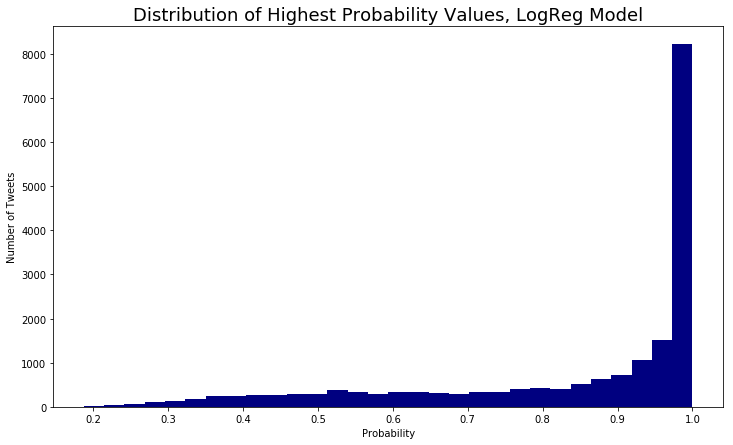

In [564]:
plt.figure(figsize=(12,7))
plt.title("Distribution of Highest Probability Values, LogReg Model", fontsize=18)
plt.xlabel("Probability")
plt.ylabel("Number of Tweets")
plt.hist(max_lr_probs, color='navy', bins=30);

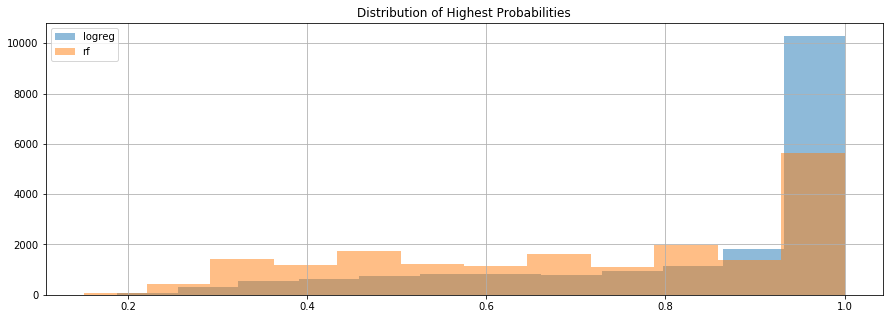

In [565]:
fig = plt.figure(figsize=(15,5))
a = 0.5
b = 12
dz = False
d = pd.DataFrame({'logreg': max_lr_probs, 'rf': max_probs})
authors = ['logreg','rf']
plt.title(s="Distribution of Highest Probabilities")
for auth in authors:
    d[auth].hist(bins=b, density=dz, alpha=a)
plt.legend(authors);

In [586]:
tweeters[:10]

['^JG', '^JP', '^BD', '^KF', '^GES', '^DG', '^JZ', '^HKD', '^RT', '^EE']

In [587]:
# show probabilities for each author ['^JG', '^JP', '^BD', '^KF', '^GES']


rf_all_probs = pd.DataFrame({
    'jg': [prob[0] for prob in probs],
    'jp': [prob[1] for prob in probs],
    'bd': [prob[2] for prob in probs],
    'kf': [prob[3] for prob in probs],
    'ges': [prob[4] for prob in probs],
    'dg': [prob[5] for prob in probs],
    'jz': [prob[6] for prob in probs],
    'hkd': [prob[7] for prob in probs],
    'rt': [prob[8] for prob in probs],
    'ee': [prob[9] for prob in probs]
})

In [589]:
rf_all_probs.head()

bd        dg        ee       ges       hkd   jg     jp        jz  \
0  0.028  0.157333  0.179778  0.000667  0.000667  0.0  0.156  0.360667   
1  0.000  1.000000  0.000000  0.000000  0.000000  0.0  0.000  0.000000   
2  0.000  0.000000  0.000000  0.000000  0.000000  0.8  0.000  0.000000   
3  0.100  0.700000  0.000000  0.050000  0.050000  0.0  0.000  0.000000   
4  0.000  0.000000  0.000000  0.000000  0.000000  0.9  0.000  0.000000   

         kf        rt  
0  0.115556  0.001333  
1  0.000000  0.000000  
2  0.050000  0.150000  
3  0.100000  0.000000  
4  0.000000  0.100000

In [590]:
X_test.shape[0]

18955

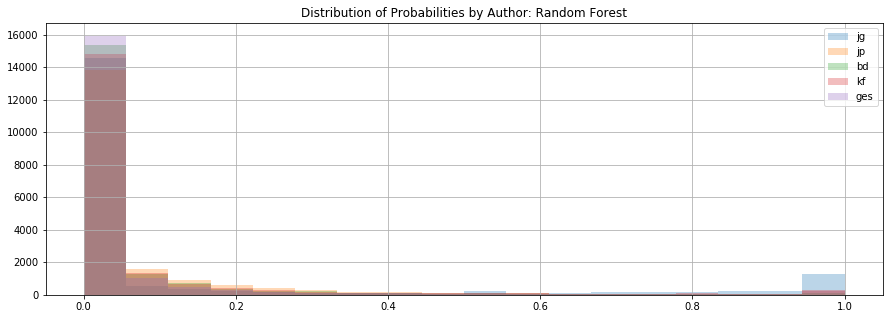

In [591]:
fig = plt.figure(figsize=(15,5))
a = 0.3
b = 18
dz = False
d = rf_all_probs
authors = ['jg', 'jp', 'bd', 'kf', 'ges']
plt.title(s="Distribution of Probabilities by Author: Random Forest")
for auth in authors:
    d[auth].hist(bins=b, density=dz, alpha=a)
plt.legend(authors);

In [592]:
lr_all_probs = pd.DataFrame({
    'jg': [prob[0] for prob in lr_probs],
    'jp': [prob[1] for prob in lr_probs],
    'bd': [prob[2] for prob in lr_probs],
    'kf': [prob[3] for prob in lr_probs],
    'ges': [prob[4] for prob in lr_probs],
    'dg': [prob[5] for prob in lr_probs],
    'jz': [prob[6] for prob in lr_probs],
    'hkd': [prob[7] for prob in lr_probs],
    'rt': [prob[8] for prob in lr_probs],
    'ee': [prob[9] for prob in lr_probs]
})

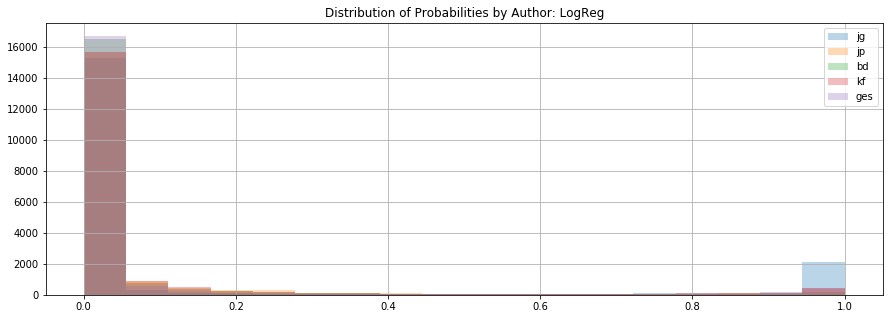

In [593]:
fig = plt.figure(figsize=(15,5))
a = 0.3
b = 18
dz = False
d = lr_all_probs
authors = ['jg', 'jp', 'bd', 'kf', 'ges']
plt.title(s="Distribution of Probabilities by Author: LogReg")
for auth in authors:
    d[auth].hist(bins=b, density=dz, alpha=a)
plt.legend(authors);

In [597]:
tweeter_titles = [n.replace('^','').lower() for n in tweeters]

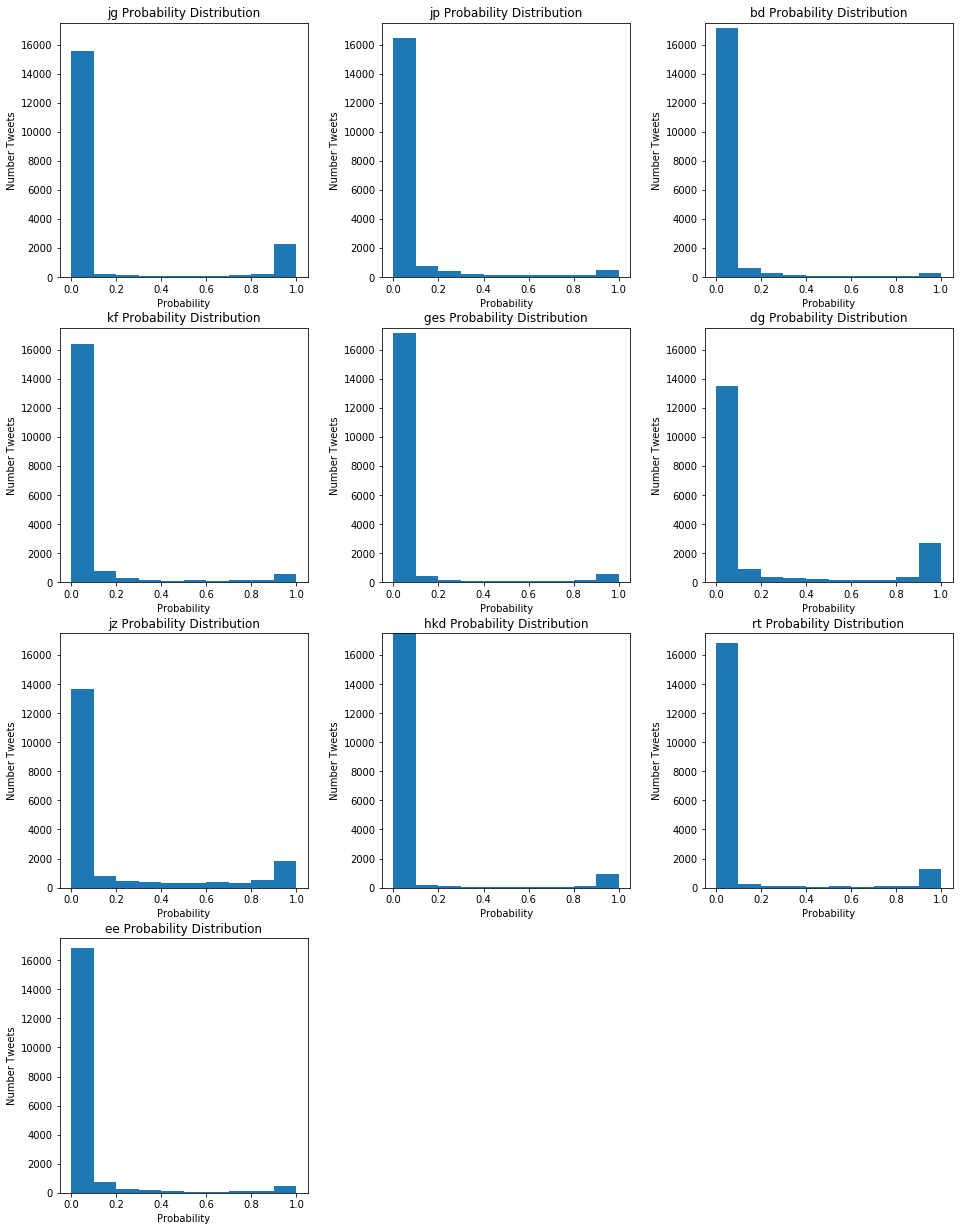

In [611]:
# For LogReg 
plt.figure(figsize=(16,10))
for dude, p in list(zip(tweeter_titles[:10], range(1,11))):
    plt.subplot(4,3,p)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.75,
                wspace=0.3, hspace=None)
    plt.ylim(0,17500)
    plt.xlabel("Probability")
    plt.ylabel("Number Tweets")
    plt.title("{} Probability Distribution".format(dude))
    plt.hist(lr_all_probs[dude])

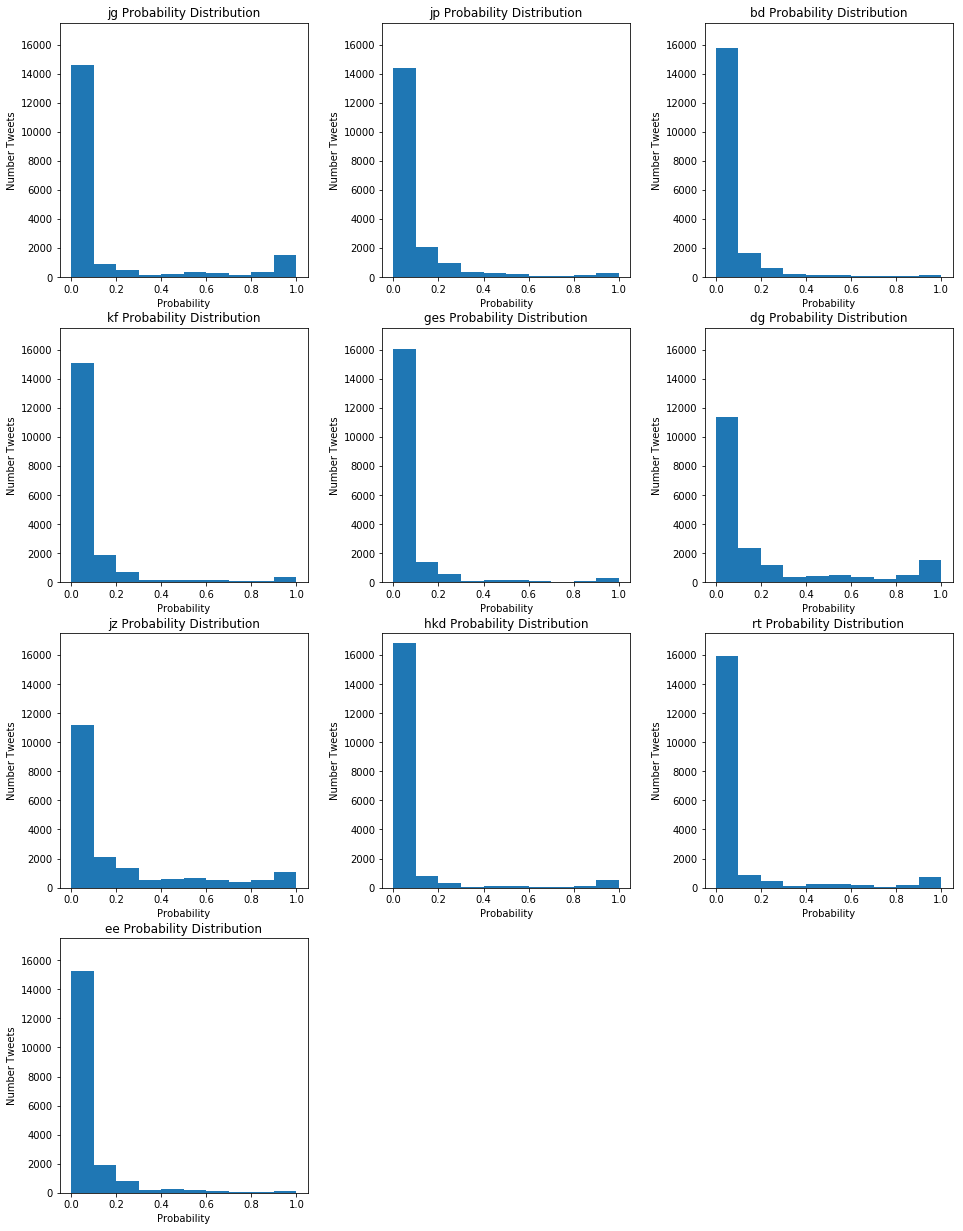

In [613]:
# For Random Forest
plt.figure(figsize=(16,10))
for dude, p in list(zip(tweeter_titles[:10], range(1,11))):
    plt.subplot(4,3,p)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.75,
                wspace=0.3, hspace=None)
    plt.ylim(0,17500)
    plt.xlabel("Probability")
    plt.ylabel("Number Tweets")
    plt.title("{} Probability Distribution".format(dude))
    plt.hist(rf_all_probs[dude])

In [461]:
# here: look at which authors use top features from rf the most

In [614]:
# df of coefs for each target in logreg model
coef_df = pd.DataFrame((lr.coef_).T, columns=tweeter_titles[:10])
coef_df.head()

jg        jp        bd        kf       ges        dg        jz  \
0 -0.172850 -0.287960  0.084425  0.170298 -0.156555 -0.305762  0.049209   
1 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
2 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
3 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
4 -0.035549 -0.198963 -0.054368  0.495864 -0.029549 -0.461121  0.302342   

        hkd        rt        ee  
0 -0.008900  0.729685 -0.101591  
1 -0.000155  0.172403 -0.001891  
2 -0.000155  0.172403 -0.001891  
3 -0.000155  0.172403 -0.001891  
4  0.006940  0.004700 -0.030295

In [615]:
coef_df['feature'] = cv.get_feature_names()
coef_df.head()

jg        jp        bd        kf       ges        dg        jz  \
0 -0.172850 -0.287960  0.084425  0.170298 -0.156555 -0.305762  0.049209   
1 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
2 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
3 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
4 -0.035549 -0.198963 -0.054368  0.495864 -0.029549 -0.461121  0.302342   

        hkd        rt        ee          feature  
0 -0.008900  0.729685 -0.101591               00  
1 -0.000155  0.172403 -0.001891          00 info  
2 -0.000155  0.172403 -0.001891      00 info web  
3 -0.000155  0.172403 -0.001891  00 info web mta  
4  0.006940  0.004700 -0.030295            00 pm

In [616]:
coef_df['abs_sum'] = np.abs(coef_df[[col for col in coef_df if col != 'feature']]).sum(axis=1)
coef_df['abs_mean'] = np.abs(coef_df[[col for col in coef_df if col != 'feature']]).mean(axis=1)

In [617]:
coef_df.head()

jg        jp        bd        kf       ges        dg        jz  \
0 -0.172850 -0.287960  0.084425  0.170298 -0.156555 -0.305762  0.049209   
1 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
2 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
3 -0.119540 -0.000602 -0.005627 -0.000786 -0.035574 -0.005080 -0.003147   
4 -0.035549 -0.198963 -0.054368  0.495864 -0.029549 -0.461121  0.302342   

        hkd        rt        ee          feature   abs_sum  abs_mean  
0 -0.008900  0.729685 -0.101591               00  2.067236  0.375861  
1 -0.000155  0.172403 -0.001891          00 info  0.344806  0.062692  
2 -0.000155  0.172403 -0.001891      00 info web  0.344806  0.062692  
3 -0.000155  0.172403 -0.001891  00 info web mta  0.344806  0.062692  
4  0.006940  0.004700 -0.030295            00 pm  1.619691  0.294489

In [618]:
coef_df.set_index('feature', inplace=True)

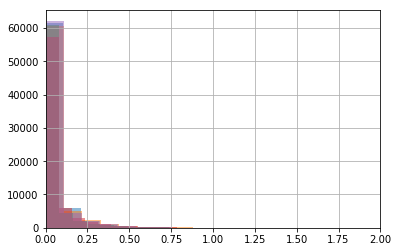

In [621]:
abs(coef_df['jg']).hist(bins=25, alpha=0.5)
abs(coef_df['jp']).hist(bins=25, alpha=0.5)
abs(coef_df['bd']).hist(bins=25, alpha=0.5)
abs(coef_df['kf']).hist(bins=25, alpha=0.5)
abs(coef_df['ges']).hist(bins=25, alpha=0.5)
plt.xlim(0,2);

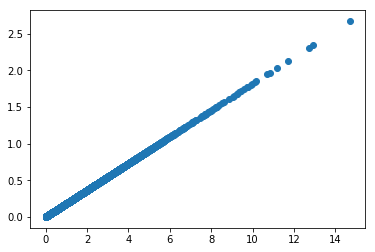

In [622]:
plt.scatter(data=coef_df, x='abs_sum', y='abs_mean')

In [623]:
abs_coef_df = abs(coef_df)
abs_coef_df.head()

jg        jp        bd        kf       ges        dg  \
feature                                                                       
00               0.172850  0.287960  0.084425  0.170298  0.156555  0.305762   
00 info          0.119540  0.000602  0.005627  0.000786  0.035574  0.005080   
00 info web      0.119540  0.000602  0.005627  0.000786  0.035574  0.005080   
00 info web mta  0.119540  0.000602  0.005627  0.000786  0.035574  0.005080   
00 pm            0.035549  0.198963  0.054368  0.495864  0.029549  0.461121   

                       jz       hkd        rt        ee   abs_sum  abs_mean  
feature                                                                      
00               0.049209  0.008900  0.729685  0.101591  2.067236  0.375861  
00 info          0.003147  0.000155  0.172403  0.001891  0.344806  0.062692  
00 info web      0.003147  0.000155  0.172403  0.001891  0.344806  0.062692  
00 info web mta  0.003147  0.000155  0.172403  0.001891  0.344806  0.062692  
00 pm            0.302342  0.006940  0.004700  0.030295  1.619691  0.294489

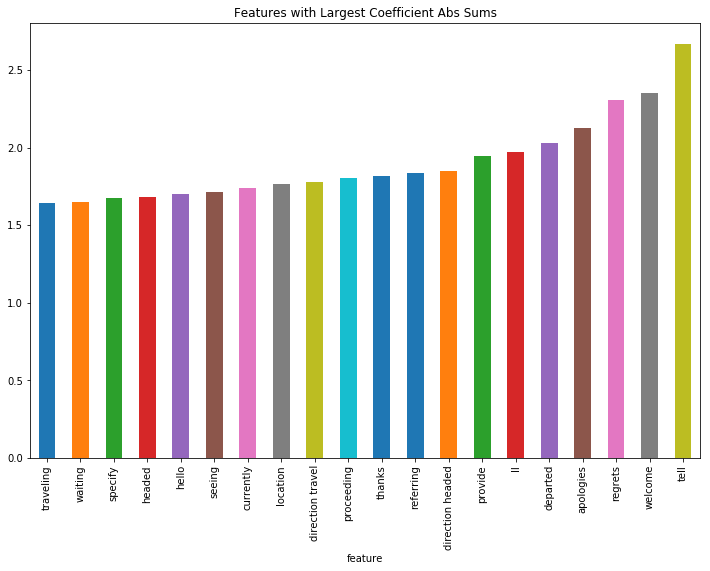

In [625]:
plt.figure(figsize=(12,8))
plt.title("Features with Largest Coefficient Abs Sums")
abs_coef_df['abs_mean'].sort_values().tail(20).plot(kind='bar')

In [626]:
# look and see if gs is a signature

df.query("sig=='^GES'")[df.query("sig=='^GES'")['text'].str.contains('GS')].text[11656]

'Hi Nadiya. Thank you for your report this morning. We have sent in your report of no AC on the C line. Have a good day. ^GS'

In [627]:
df.text.str.contains("GS").sum()
# went back and added GS/gs to stop words

482

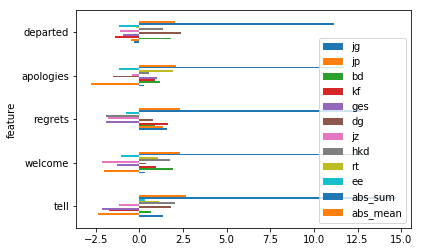

In [630]:
# look at info for top features for each author

coef_df.sort_values('abs_sum', ascending=False).head().plot(kind='barh')

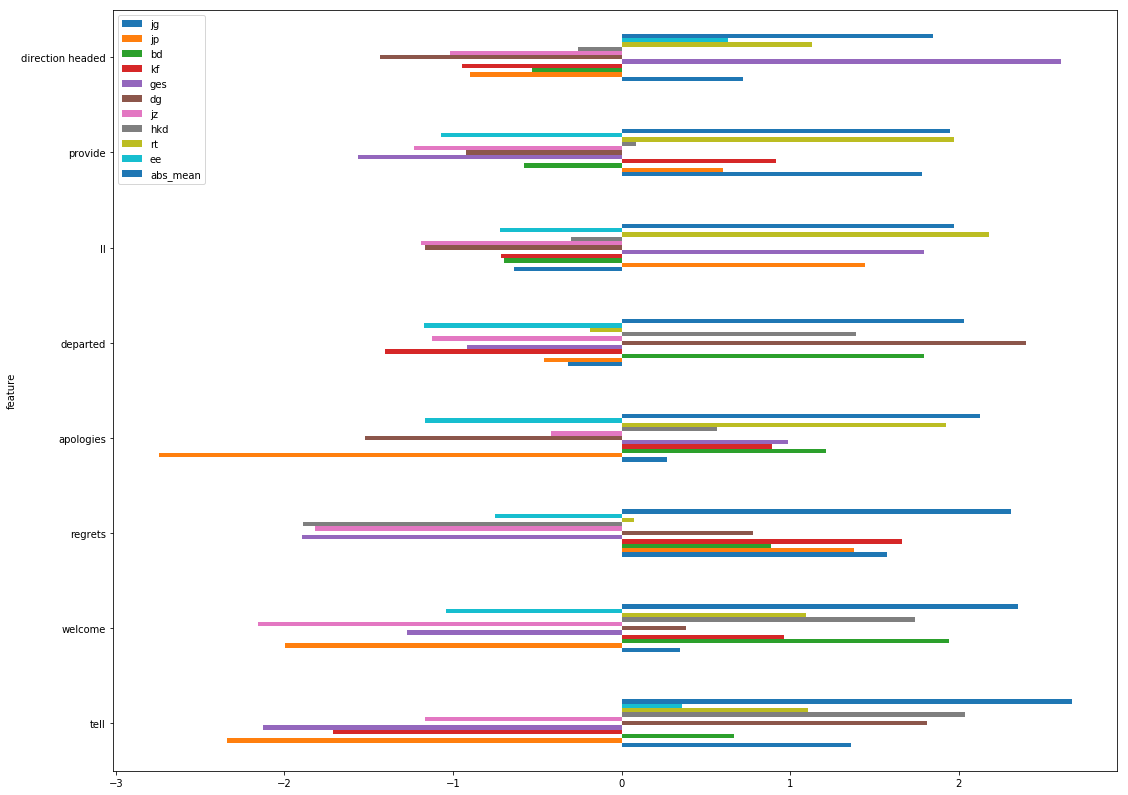

In [636]:
coef_df[[col for col in coef_df.columns if col !='abs_sum']].sort_values('abs_mean', ascending=False).head(8).plot\
(kind='barh',figsize=(18,14))

**Wordclouds!**

In [113]:
from wordcloud import WordCloud

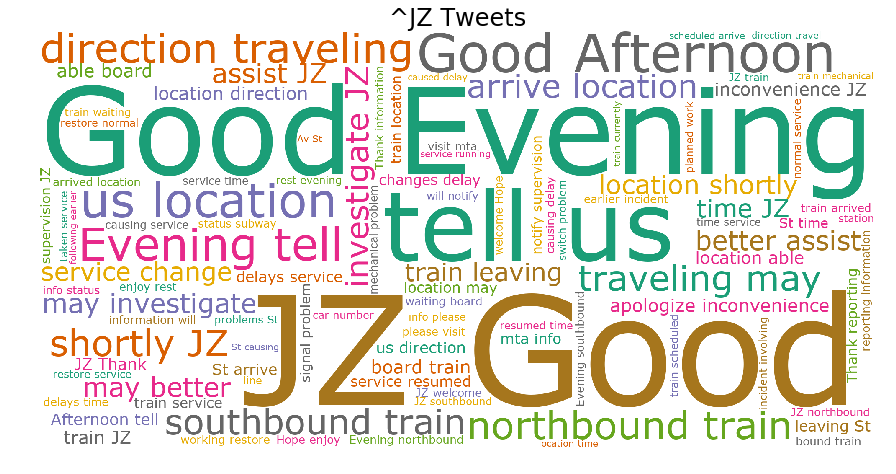

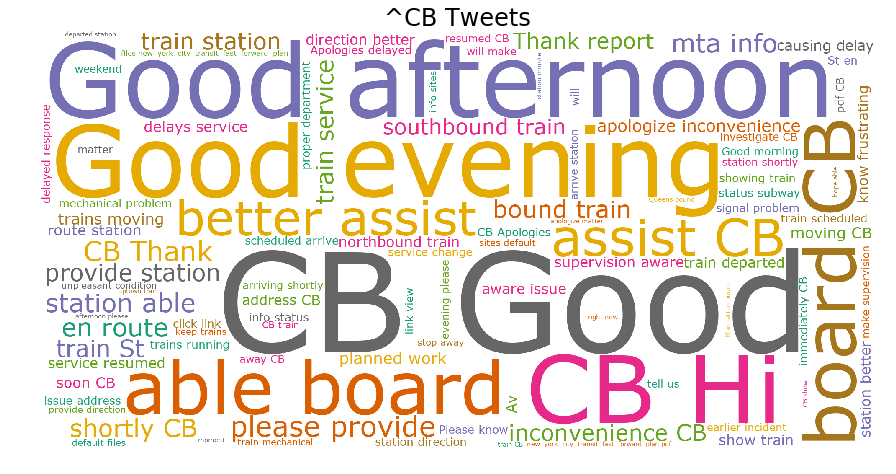

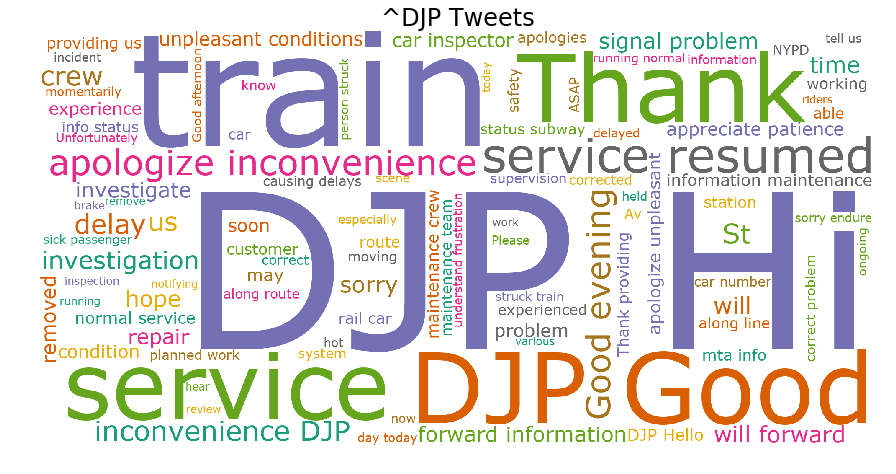

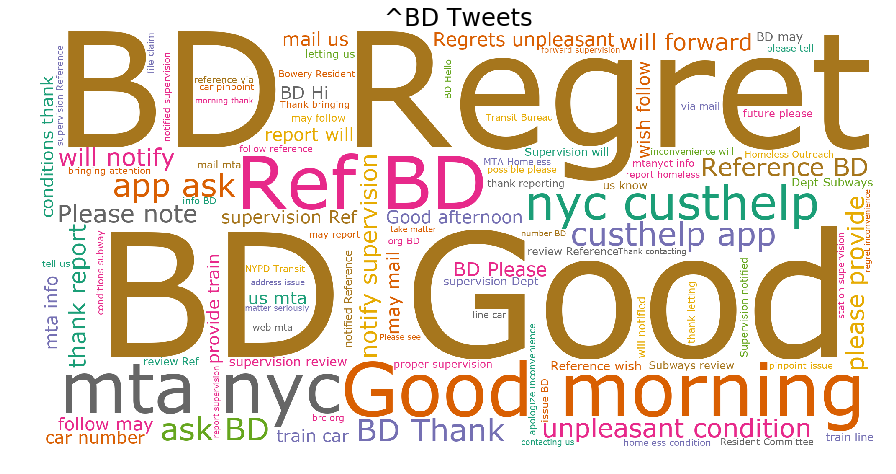

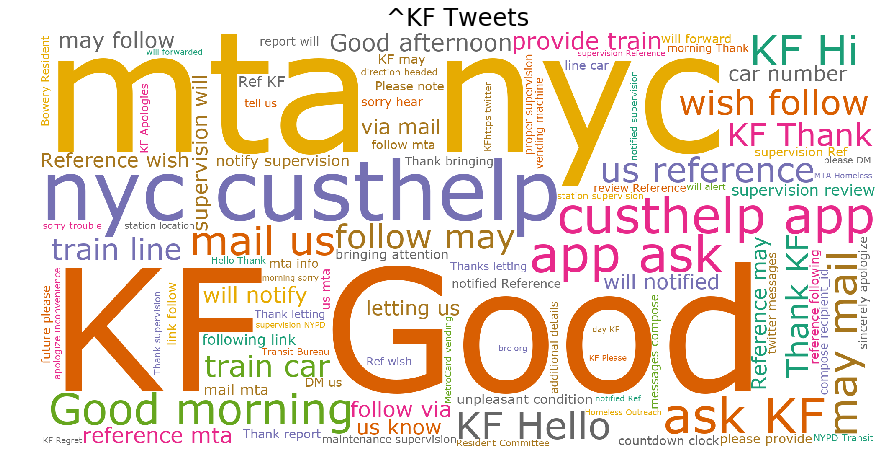

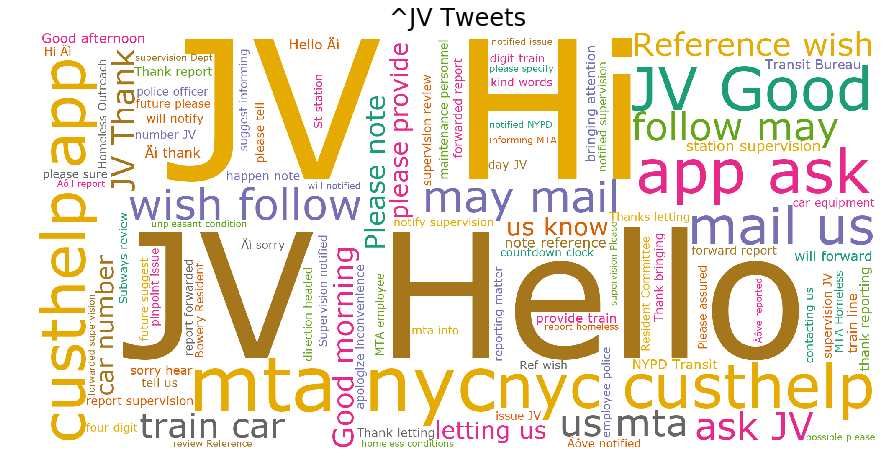

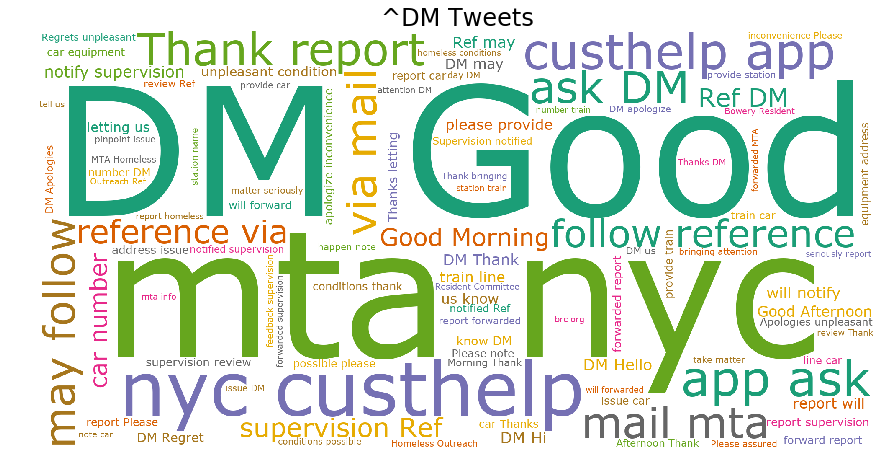

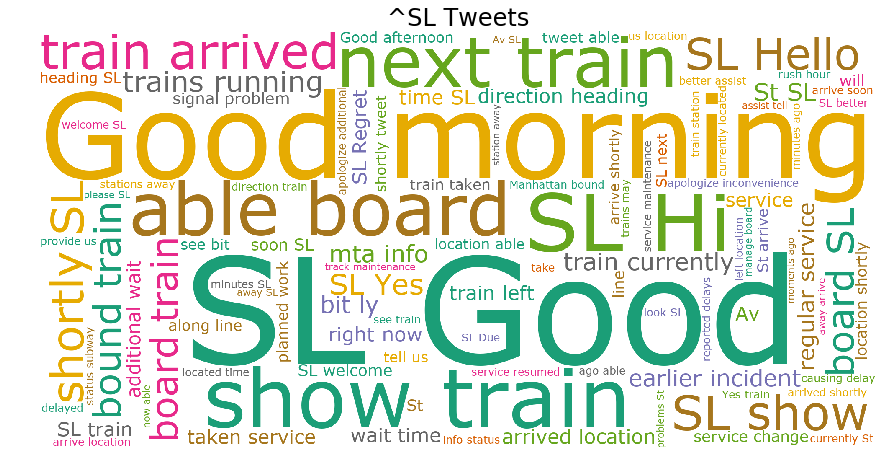

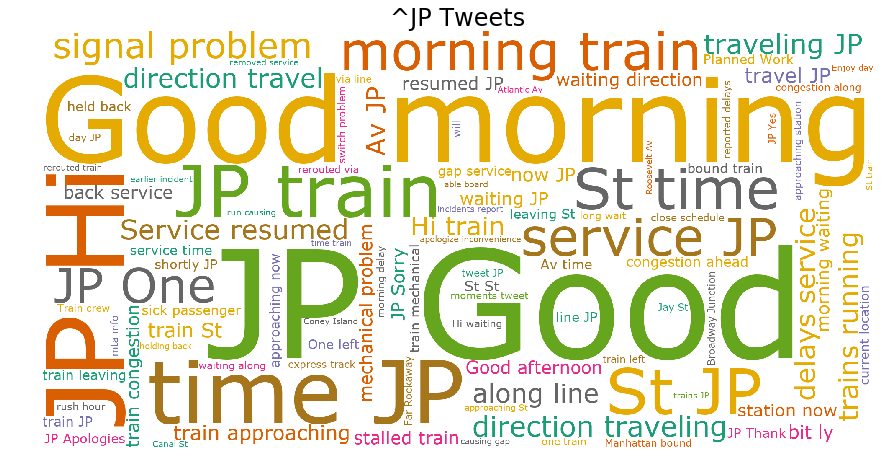

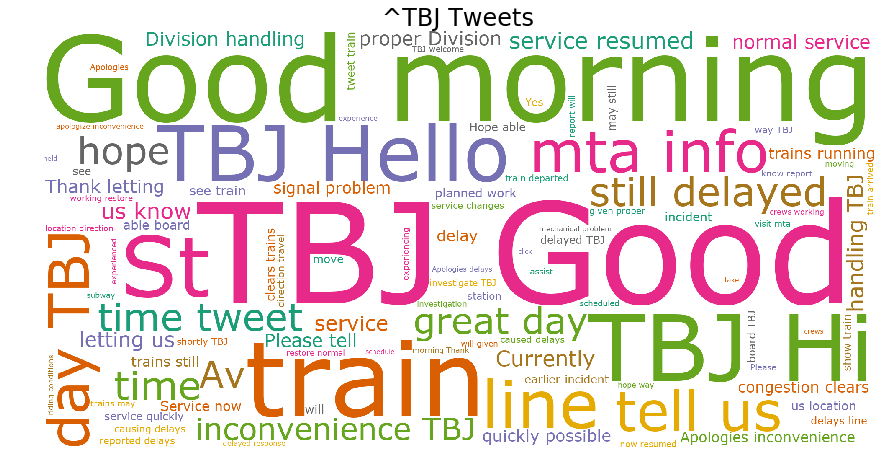

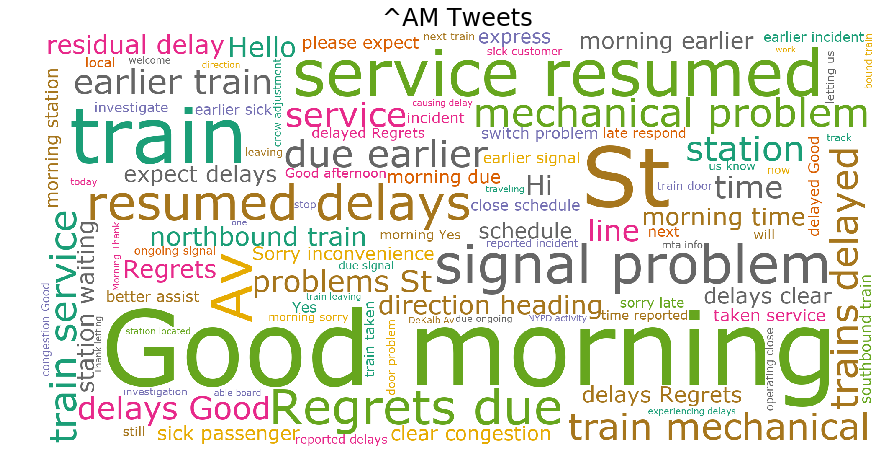

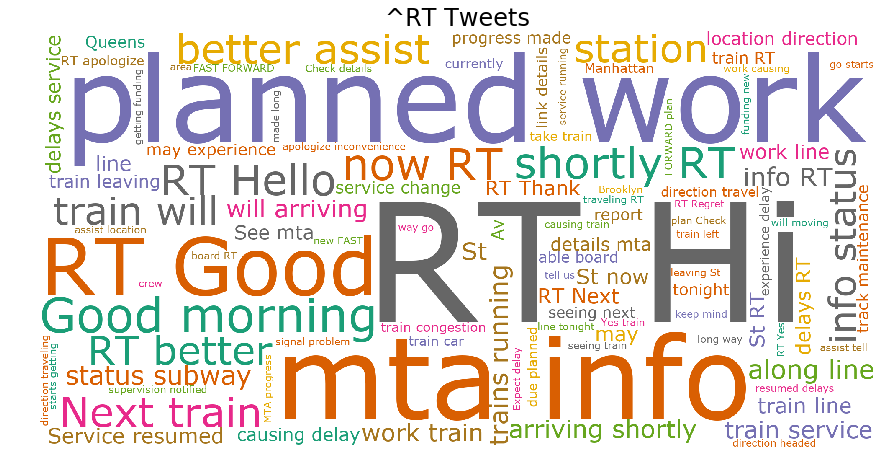

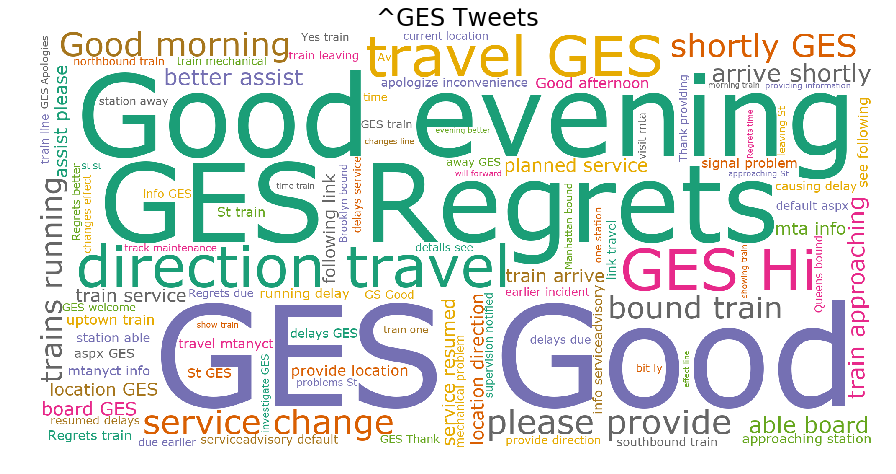

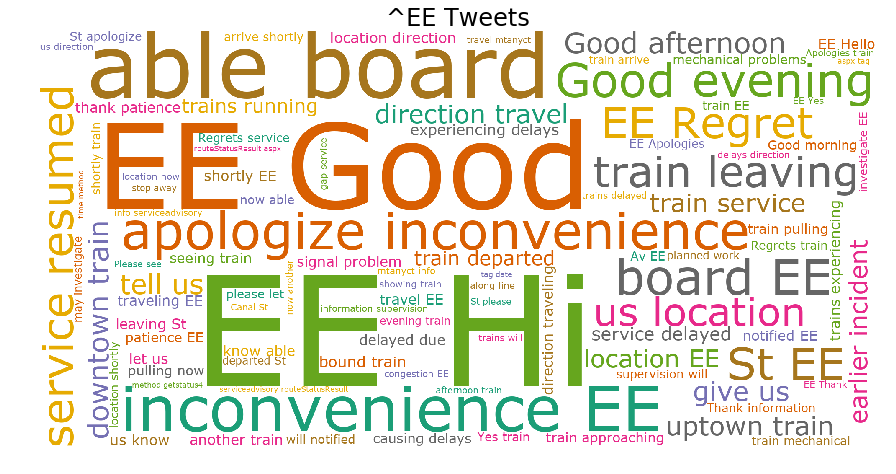

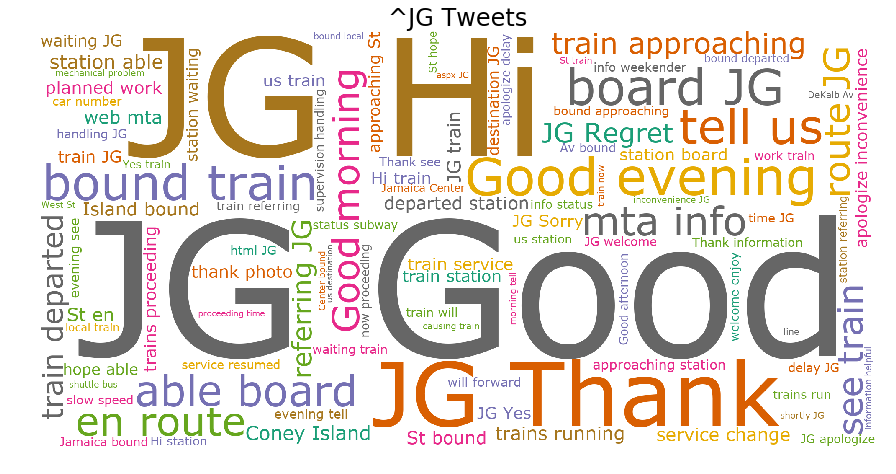

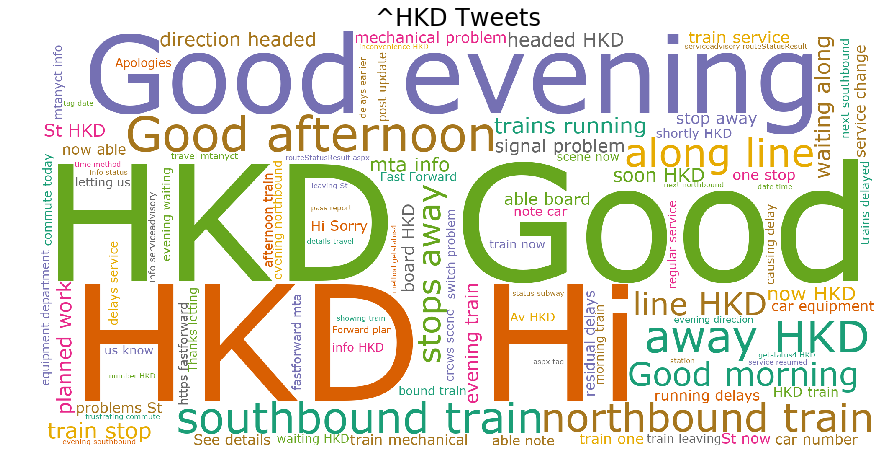

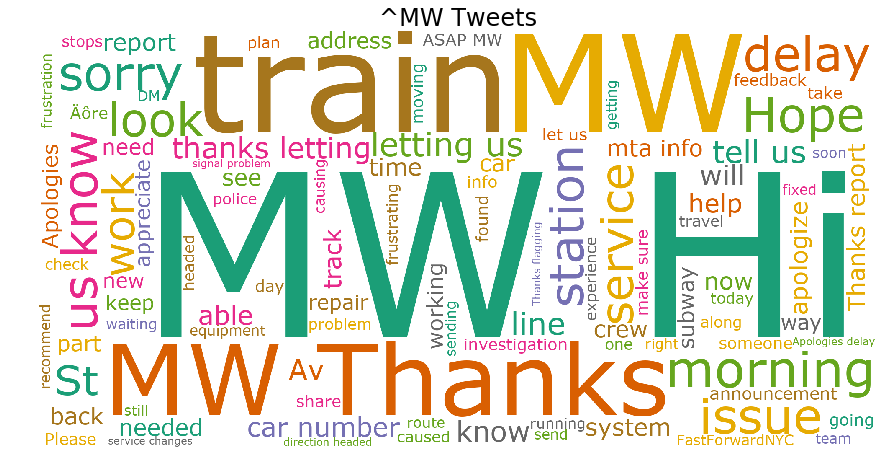

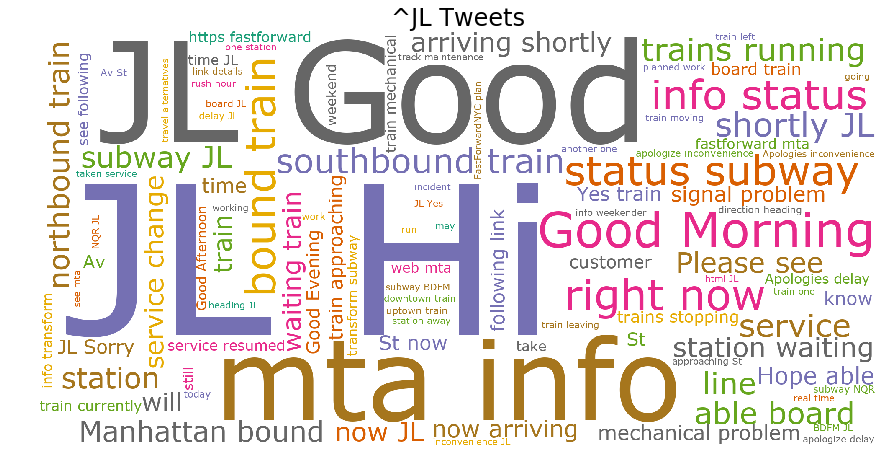

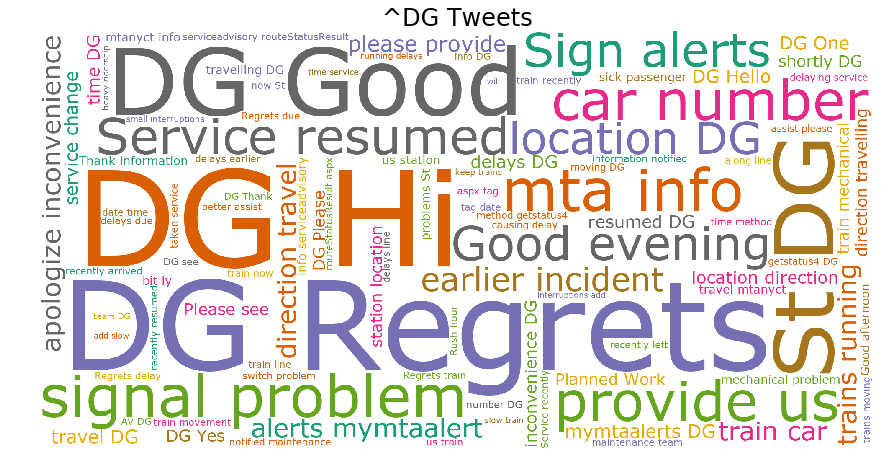

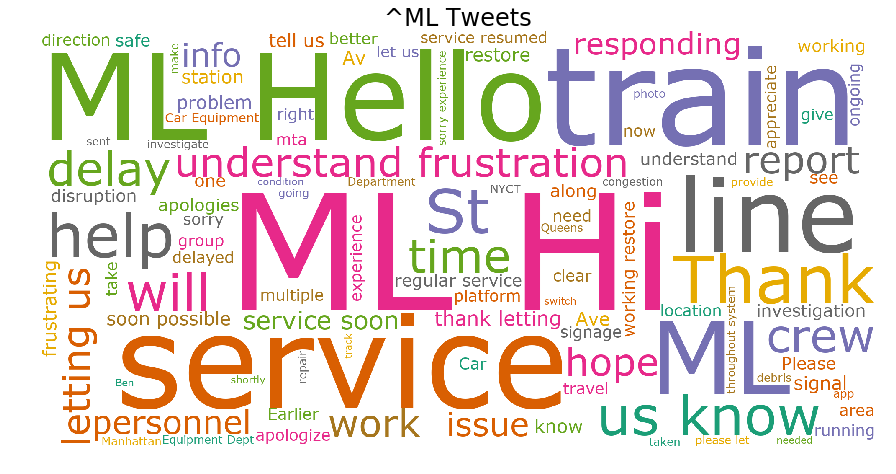

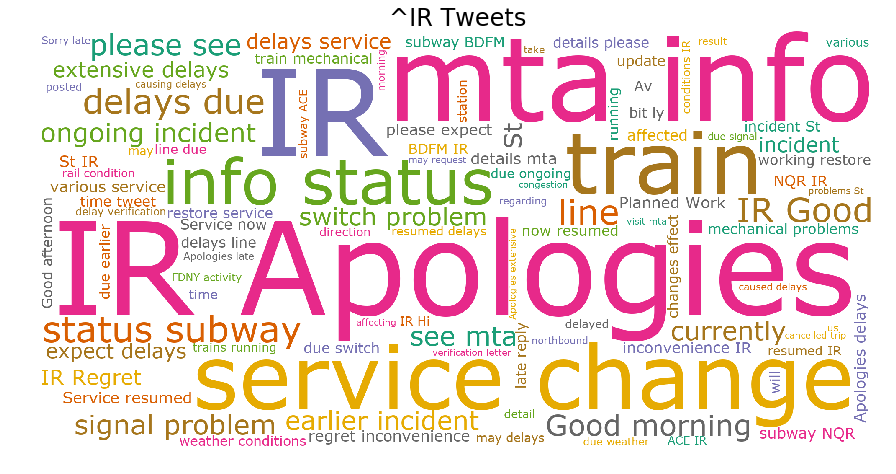

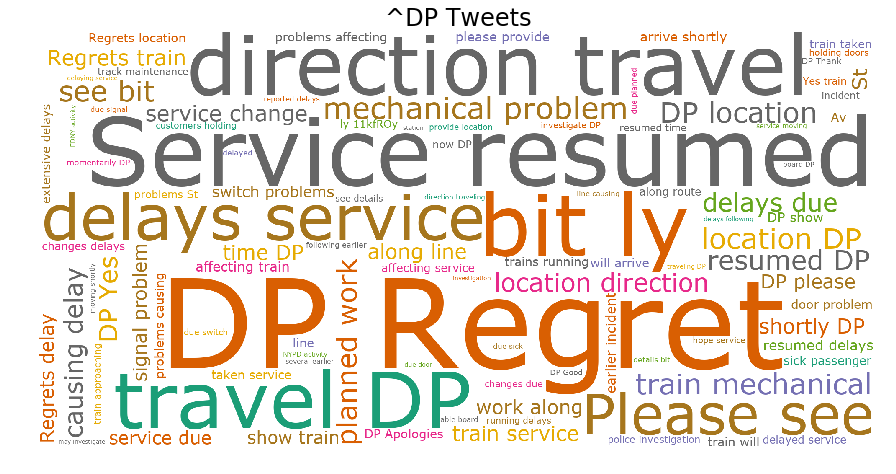

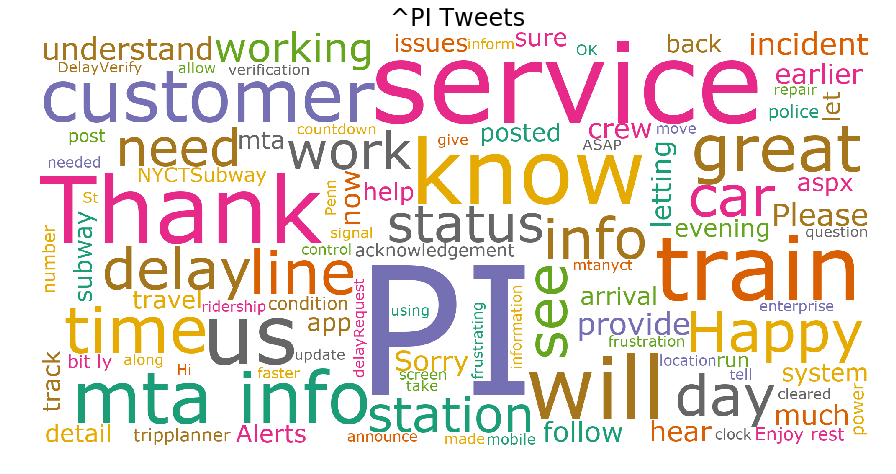

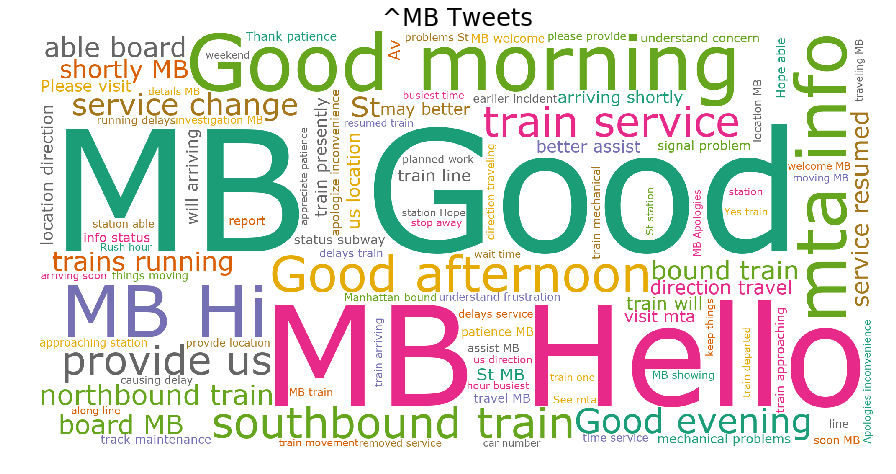

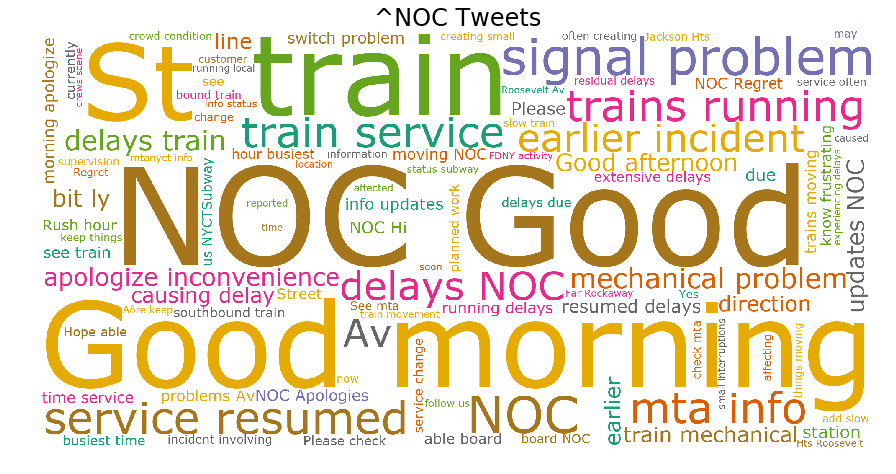

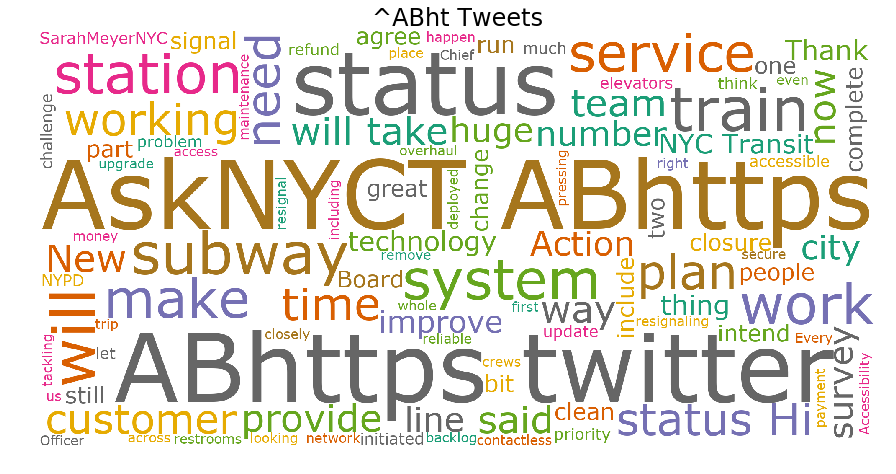

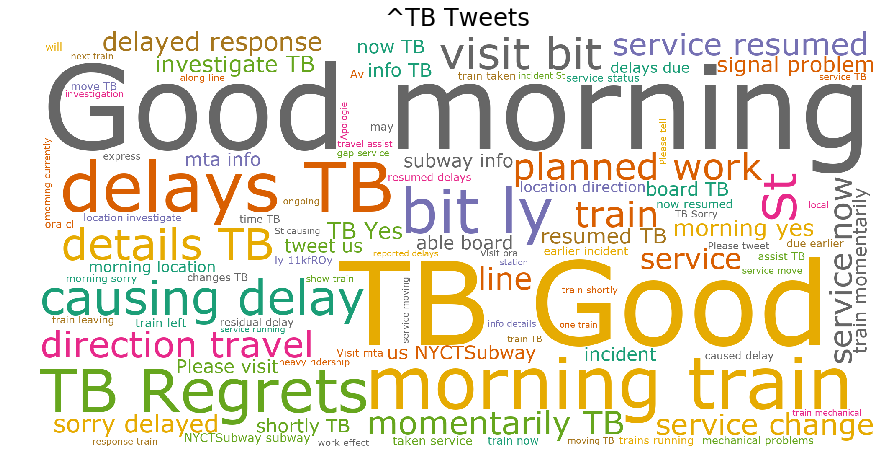

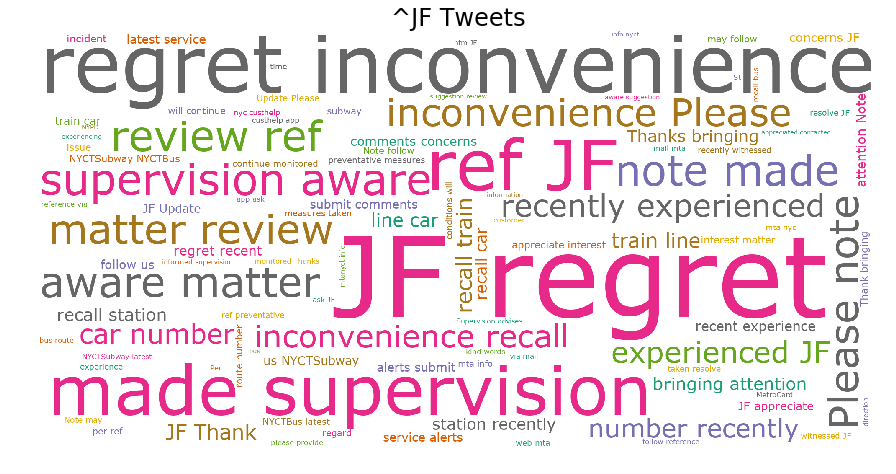

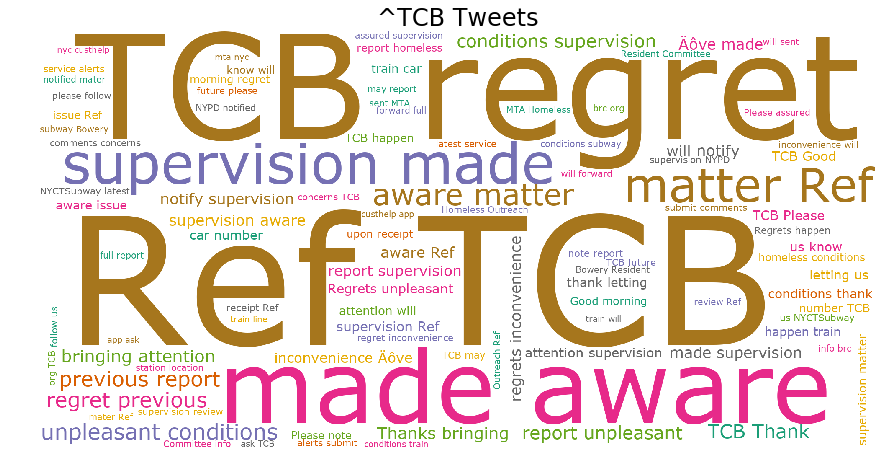

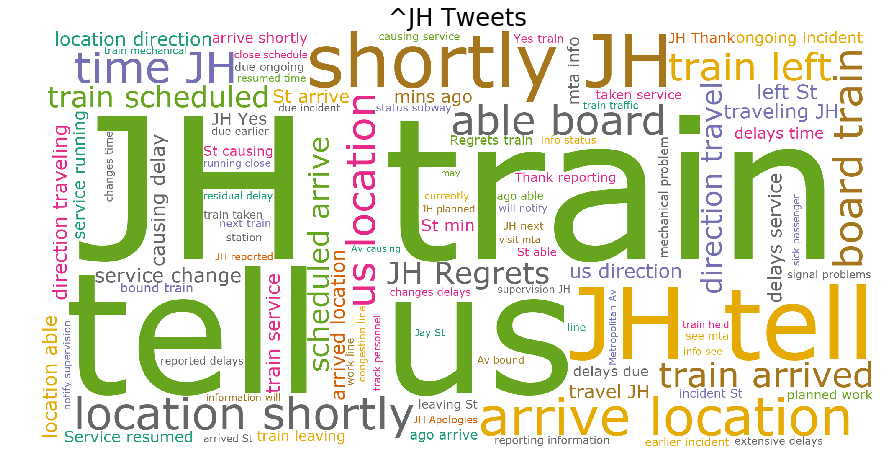

In [637]:
sig_list = [sig for sig in list(df['sig'].unique()) if sig != None]

for poop in sig_list:
    plt.figure(figsize=(15,8))
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      max_words=(100),
                      width=2000, height=1000,
                      relative_scaling = 0.5,
                      background_color='white',
                      colormap='Dark2'                  
    ).generate(' '.join(df[df['sig']==poop].text))
    plt.imshow(wordcloud)
    plt.title("{} Tweets".format(poop), fontsize=24)
    plt.axis("off")
    plt.show()